# Inspecting the Ported 91bg Model

#### Table of Contents:
1. <a href='#parameter_covarience'>Parameter Covarience</a>: Demonstrates the covarience between stretch and color for 91bgs
1. <a href='#spectral_evolution'>Spectral Evolution</a>: Plots spectra as a function of phase
1. <a href='#photometric_evolution'>Photometric Evolution</a>: Explore modeled flux and colors over time
1. <a href='#s2_parameters'>Comparison with Salt2 Parameters</a>: Comparison of simulated salt2 parameters against best fit 91bg parameters.
1. <a href='#hsiao'>Comparison with Hsiao</a>: Comparison of the light-curve morphologies for the `sn91bg` and `hsiao` models.
1. <a href='#fits_to_data'>Fits to Real Data</a>: Comparison of the models fir to CSP data.


In [1]:
import sys
from pathlib import Path

import numpy as np
import sncosmo
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, NullFormatter, AutoMinorLocator
from sndata.csp import dr3
from sndata.sdss import sako18
from tqdm import tqdm

sys.path.insert(0, '../')
from phot_class import fitting, models, utils
from phot_class import simulation as sncosmo_sims


In [2]:
# Output directory for figures
fig_dir = Path('./notebook_figs/model_inspection')
fig_dir.mkdir(exist_ok=True, parents=True)

models.register_sources(force=True)
bg_source = sncosmo.get_source('sn91bg')

dr3.download_module_data()
dr3.register_filters(True)

sako18.download_module_data()
sako18.register_filters(True)

print('Source Summary:\n')
print(bg_source)


Source Summary:

class      : SN91bg
name       : 'sn91bg'
version    : salt2_phase
phases     : [-18, .., 50] days
wavelengths: [1000, .., 12000] Angstroms
parameters:
  amplitude = 1.0
  x1        = 1.0
  c         = 0.55


## Parameter Covarience <a id='parameter_covarience'></a>

We consider the expected covarience between stretch and color in 91bg like supernovae. Note that our 91bg model does not intrinsically consider this covarience.


In [3]:
def plot_hexbin(x, y, xlim, ylim, fig_size=(8, 8), bins=50):
    """Plot a hexbin with x and y histograms
    
    Args:
      x      (ndarray):
      x      (ndarray):
      xlim     (tuple): x limits for the plot
      ylim     (tuple): y limits for the plot
      fig_size (tuple): x and y dimensions for the figure
      bins       (int): Number of bins to use
      
    Returns:
        A matplotlib figure
        The axis of the main subplot
        The axis of the x histogram
        The axis of the y histogram
    """

    # Define axis coordinates
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # Instantiate figure
    fig = plt.figure(1, fig_size)

    ax_main = plt.axes(rect_scatter)
    ax_hist_x = plt.axes(rect_histx)
    ax_hist_y = plt.axes(rect_histy)

    # Remove labels from histogram axes
    nullfmt = NullFormatter() 
    ax_hist_x.xaxis.set_major_formatter(nullfmt)
    ax_hist_y.yaxis.set_major_formatter(nullfmt)

    # The hexbin
    ax_main.hexbin(x, y, gridsize=(bins, bins), cmap='Blues')
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(ylim)

    # The histograms
    avg_x = np.average(x)
    std_x = np.std(x)
    ax_hist_x.hist(x, bins=bins) 
    ax_hist_x.axvline(avg_x, color='black', linestyle='--', label='Average')
    ax_hist_x.axvline(avg_x + std_x, color='black', linestyle=':')
    ax_hist_x.axvline(avg_x - std_x, color='black', linestyle=':', 
                      label='Standard Deviation')
    
    avg_y = np.average(y)
    std_y = np.std(y)
    ax_hist_y.hist(y, bins=bins, orientation='horizontal')
    ax_hist_y.axhline(avg_y, color='black', linestyle='--')
    ax_hist_y.axhline(avg_y + std_y, color='black', linestyle=':')
    ax_hist_y.axhline(avg_y - std_y, color='black', linestyle=':')

    ax_hist_x.set_xlim(ax_main.get_xlim())
    ax_hist_y.set_ylim(ax_main.get_ylim())

    return fig, ax_main, ax_hist_x, ax_hist_y
    

In [4]:
stretch, color = sncosmo_sims.bg_stretch_color(
    size=1e6, 
    min_stretch=-np.inf, 
    min_color=-np.inf, 
    max_stretch=np.inf, 
    max_color=np.inf)


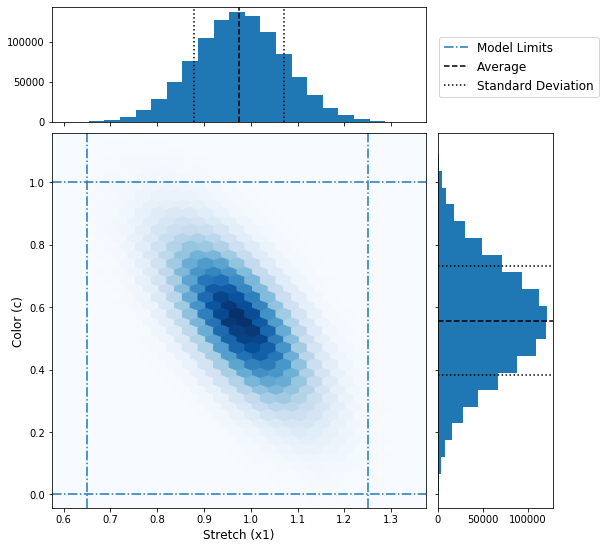

In [5]:
xlim = (sncosmo_sims.avg_stretch - .4, sncosmo_sims.avg_stretch + .4)
ylim = (sncosmo_sims.avg_color - .6, sncosmo_sims.avg_color + .6)
fig, *axes = plot_hexbin(stretch, color, xlim, ylim, bins=30)

axes[0].axvline(min(bg_source._stretch), linestyle='-.')
axes[0].axvline(max(bg_source._stretch), linestyle='-.')
axes[0].axhline(min(bg_source._color), linestyle='-.')
axes[0].axhline(max(bg_source._color), linestyle='-.', label='Model Limits')

axes[0].set_xlabel('Stretch (x1)', fontsize=12)
axes[0].set_ylabel('Color (c)', fontsize=12)
fig.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.05, .9))

plt.savefig(fig_dir / '91bg_x1_c_covariance.pdf')
plt.show()


## Spectral Evolution <a id='spectral_evolution'></a>

We plot the spectra over some phase range in arbitrary flux units

In [6]:
def plot_bg_spectral_evolution(phase_range, source, offset):
    """Plot spectral evolution over time
    
    Args:
        phase_range (tuple): Phase range to plot the model over
        source     (Source): Sncosmo Source to use for flux modeling
        offset      (float): The vertical offset between each spectrum
    
    Returns:
        A matplotlib figure
        An array with the axes of the figure
    """
    
    phase_arr = np.arange(*phase_range)
    wave_arr = np.arange(source.minwave(), source.maxwave())
    flux_arr = source.flux(phase_arr, wave_arr)
    plot_data = zip(phase_arr, flux_arr)

    fig, axis_left = plt.subplots(1, 1, figsize=(6, 10))
    spectrum_y_coords = []
    for num_spectra, (phase, flux) in enumerate(plot_data):
        if phase_range[0] <= phase and phase < phase_range[1]:
            flux_with_offset = flux + num_spectra * offset
            spectrum_y_coords.append(flux_with_offset[-1])
            axis_left.plot(wave_arr, flux_with_offset, label=str(phase))

    # Si II and Fe II
    si1 = axis_left.axvline(4130, linestyle='--', color='grey', alpha=1)
    si2 = axis_left.axvline(5972, linestyle='--', color='grey', alpha=1)
    si3 = axis_left.axvline(6355, linestyle='--', color='grey', alpha=1)
    fe1 = axis_left.axvline(4950, linestyle=':', color='grey', alpha=1)

    # Format axes
    axis_left.set_xlim(min(wave_arr), max(wave_arr))
    axis_left.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
    axis_left.set_title(f'{min(phase_arr)} to {max(phase_arr)} days', fontsize=14)
    axis_left.set_ylabel(r'Flux + C', fontsize=14)
    
    axis_right = axis_left.twinx()
    axis_right.set_ylim(axis_left.get_ylim())
    axis_right.set_yticks(spectrum_y_coords)
    axis_right.set_yticklabels(phase_arr)
    axis_right.set_yticklabels(phase_arr)
    axis_right.set_ylabel('Phase (Days)', fontsize=14)
    
    for tick_axis in (axis_left.xaxis, axis_left.yaxis, axis_right.yaxis):
        for tick in tick_axis.get_major_ticks():
            tick.label.set_fontsize(14) 

    fig.legend(
        (si1, si2, si3, fe1), 
        (r'Si II ($4130 \AA$)',
         r'Si II ($5972 \AA$)', 
         r'Si II ($6355 \AA$)', 
         r'Fe II ($4950 \AA$)'), 
        fontsize=14, framealpha=1)
    

    plt.tight_layout()
    return fig, axis_left


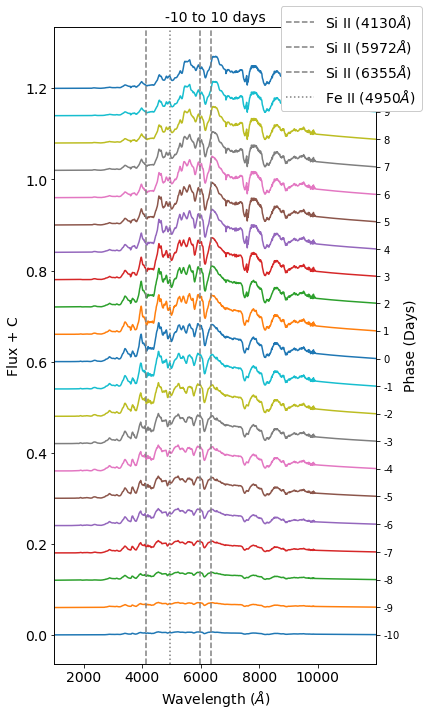

In [7]:
plot_bg_spectral_evolution((-10, 11), bg_source, offset=0.06)
# plt.savefig(fig_dir / '91bg_spectral_evolution.pdf')
plt.show()


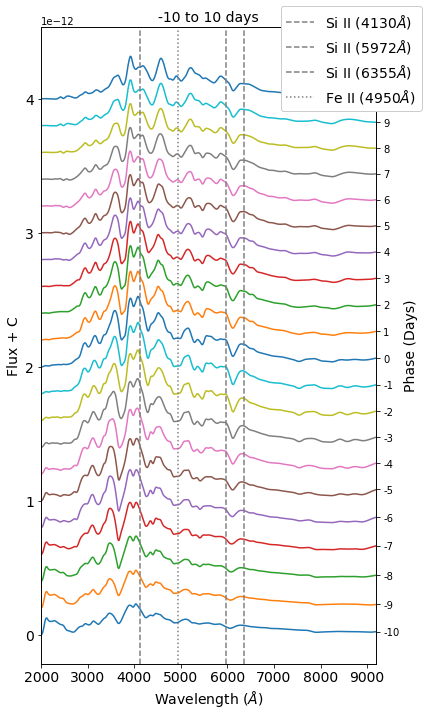

In [8]:
salt2 = sncosmo.get_source('salt2')
plot_bg_spectral_evolution((-10, 11), salt2, offset=2e-13)
# plt.savefig(fig_dir / 'salt2_spectral_evolution.pdf')
plt.show()


## Photometric Evolution <a id='photometric_evolution'></a>

We explore the predicted flux and colors of our ported 91bg model. We arbitrarily choose to use the CSP band passes.


In [9]:
# A set of fiducial band passes.
unique_bands = (
    'csp_dr3_u',
    'csp_dr3_g',
    'csp_dr3_r',
    'csp_dr3_i',
    'csp_dr3_B',
    'csp_dr3_V'
)


In [10]:
def plot_flux_for_param(source, param_name, param_value):
    """Plot a modeled light curve over the range of a given param
    
    Args:
        source    (Source): An sncosmo source class
        param_name   (str): Name of the param to vary
        param_value  (str): Values of the param to plot
    """

    model = sncosmo.Model(source)
    phase = np.arange(model.mintime(), model.maxtime())
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    for band, axis in zip(unique_bands, axes.flatten()):
        for p_val in param_value:
            model.update({param_name: p_val})
            flux = model.bandflux(band, phase, zp=25, zpsys='AB')
            # flux /= np.max(flux)
            axis.plot(phase, flux, label=f'{param_name} = {p_val}')
            axis.set_xlabel('Time')
            axis.set_ylabel('Flux')
            axis.set_title(band)
            axis.legend()


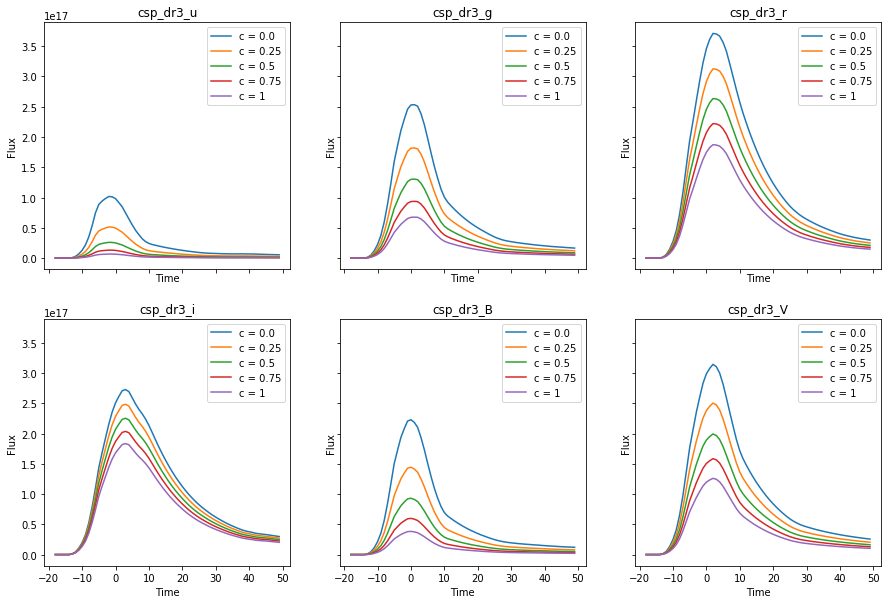

In [11]:
plot_flux_for_param(bg_source, 'c', (0.0, 0.25, 0.5, 0.75, 1))
# plt.savefig(fig_dir / '91bg_flux_color_evolution.pdf')
plt.show()


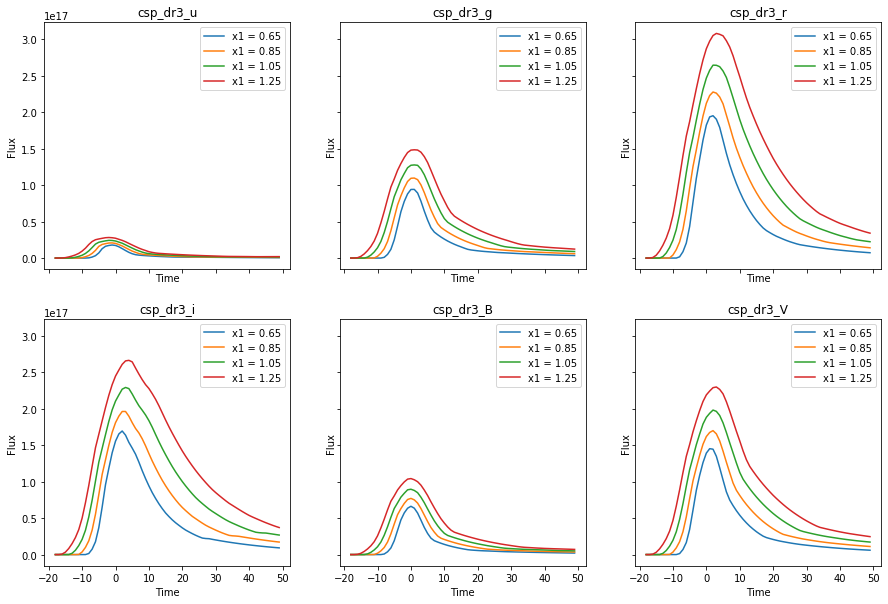

In [12]:
plot_flux_for_param(bg_source, 'x1', (0.65, 0.85, 1.05, 1.25))
# plt.savefig(fig_dir / '91bg_flux_stretch_evolution.pdf')
plt.show()


In [13]:
def plot_color_for_param(source, colors, param_name, param_value):
    """Plot a modeled light curve over the range of a given param
    
    Args:
        source    (Source): An sncosmo source class
        param_name   (str): Name of the param to vary
        param_value  (str): Values of the param to plot
    """

    model = sncosmo.Model(source)
    phase = np.arange(model.mintime(), model.maxtime())
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
    for (band1, band2), axis in zip(colors, axes.flatten()):
        for p_val in param_value:
            model.update({param_name: p_val})
            color = model.color(band1, band2, 'ab', phase)
            axis.plot(phase, color, label=f'{param_name} = {p_val}')
            axis.set_xlabel('Time')
            axis.set_ylabel('Color')
            axis.set_title(f'{band1} - {band2}')
            axis.legend()
            
    plt.tight_layout()


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


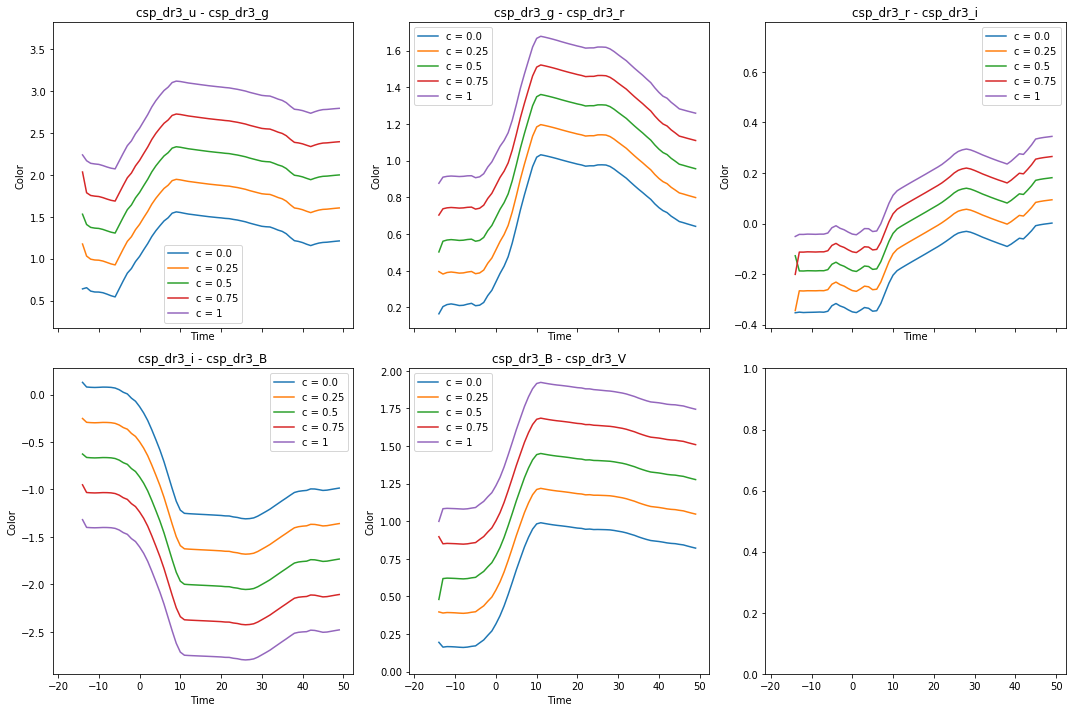

In [14]:
colors = tuple((unique_bands[i], unique_bands[i + 1]) for i in range(len(unique_bands) - 1))
plot_color_for_param(bg_source, colors, 'c', (0.0, 0.25, 0.5, 0.75, 1))
plt.show()


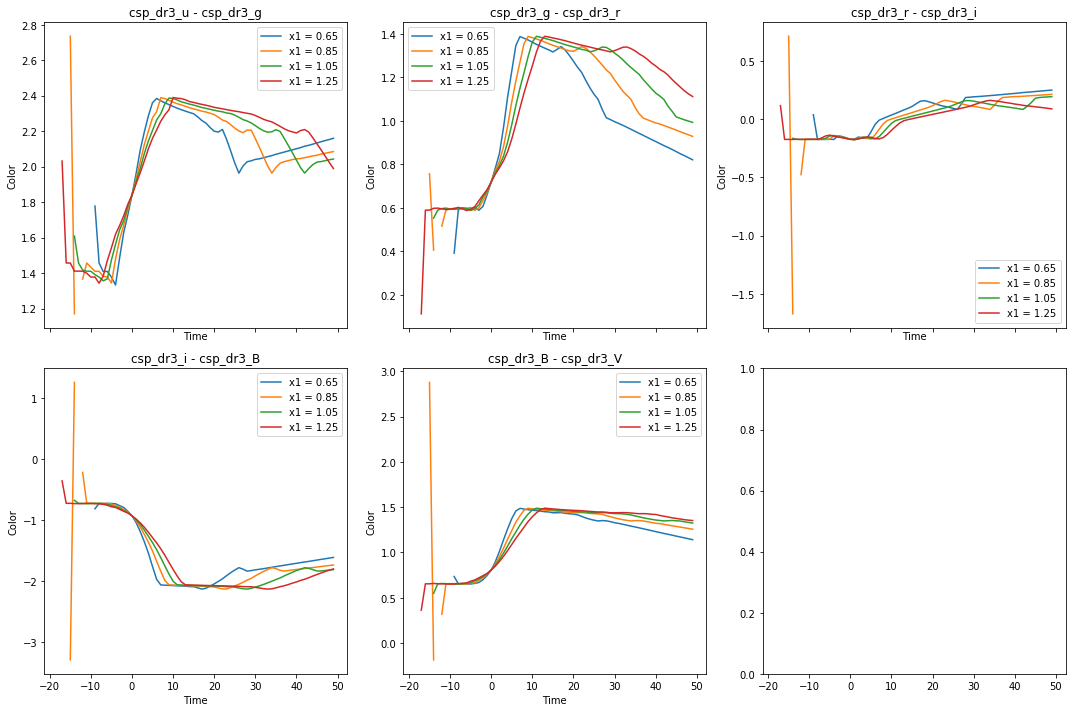

In [15]:
plot_color_for_param(bg_source, colors, 'x1', (0.65, 0.85, 1.05, 1.25))
plt.show()


## Comparison with Salt2 Parameters <a id='s2_parameters'></a>


We consider the correlation between salt2 and 91bg fit parameters - specificaly between stretch and color. We do this by simulating light curves with salt2, fitting each light curve with our 91bg model, and then plotting the relationship between the input and output parameters. 

First we create a set table of simulated observations that defines the cadence of our simulated light curves.

In [16]:
time = 6 * np.arange(-10, 30, 3).tolist()
bands = np.concatenate(
    [np.full(len(time) // 6, 'LSST' + band) for band in 'ugrizy']
)

table_length = len(time)
observations = Table(
    {'time': time,
     'band': bands,
     'gain': np.full(table_length, 1.0),
     'skynoise': np.zeros(table_length),
     'zp': np.full(table_length, 27.5),
     'zpsys': np.full(table_length, 'ab')})

observations


time,band,gain,skynoise,zp,zpsys
int64,str5,float64,float64,float64,str2
-10,LSSTu,1.0,0.0,27.5,ab
-7,LSSTu,1.0,0.0,27.5,ab
-4,LSSTu,1.0,0.0,27.5,ab
-1,LSSTu,1.0,0.0,27.5,ab
2,LSSTu,1.0,0.0,27.5,ab
5,LSSTu,1.0,0.0,27.5,ab
8,LSSTu,1.0,0.0,27.5,ab
11,LSSTu,1.0,0.0,27.5,ab
14,LSSTu,1.0,0.0,27.5,ab


Next, we generate a dictionary of parameters for each light curve we want to simulate, and run the simulations.

In [17]:
z=0
bg_param_list = []
dx = .1

stretch = np.arange(0.65, 1.25 + dx, dx)
color = np.arange(0, 1 + dx, dx)
for x1 in stretch:
    for c in color:
        bg_param_list.append({'z': z, 'x1': np.round(x1, 2), 'c': np.round(c, 2)})

sn91bg = sncosmo.Model('sn91bg')
light_curves = sncosmo.realize_lcs(observations, sn91bg, bg_param_list)


Each of these light curves are then fit with the 91bg model. For conveniance, we cache results to file. We also typcast the salt2 and 91bg model parameters from lists of dictionaries to astropy tables.

In [18]:
salt2 = sncosmo.Model('salt2')
salt2.set(z=z)

s2_param_list = []
bounds = {'c': [-3, 3], 'x1': [-6, 5]}  # To prevent runaway
for lc in tqdm(light_curves):
    result, fm = sncosmo.fit_lc(lc, salt2, ['x0', 'x1', 'c'], bounds=bounds)
    result_dict = {p:v for p, v in zip(result.param_names, result.parameters)}
    s2_param_list.append(result_dict)

s2_parameters = Table(rows=s2_param_list)
bg_parameters = Table(rows=bg_param_list) 


  0%|          | 0/77 [00:00<?, ?it/s]/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/sncosmo/fitting.py:158: RuntimeWarning: Dropping following bands from data: lssty, lsstz(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)
  1%|▏         | 1/77 [00:00<00:16,  4.53it/s]/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/sncosmo/fitting.py:158: RuntimeWarning: Dropping following bands from data: lssty, lsstz(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)
100%|██████████| 77/77 [00:13<00:00,  5.52it/s]


Finally, we plot the relationship between the parameters.

In [19]:
def scatter_plot_parameters(simulated_params, fit_params):
    """Plot fitted parameters against simulated parameters as a color plot
    
    Args:
        simulated_params (Table): A table of simulated parameter values
        fit_params       (Table): A table of fitted parameter values
        
    Returns:
        A matplotlib figure
        An array with the axes of the figure
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(simulated_params['c'], fit_params['c'], c=fit_params['x1'])      
    axes[0].set_xlabel('SN91bg Color', fontsize=14)
    axes[0].set_ylabel('Salt2 Color', fontsize=14)
    
    axes[1].scatter(simulated_params['x1'], fit_params['x1'], c=fit_params['c'])      
    axes[1].set_xlabel('SN91bg Stretch', fontsize=14)
    axes[1].set_ylabel('Salt2 Stretch', fontsize=14)
    
    plt.tight_layout()


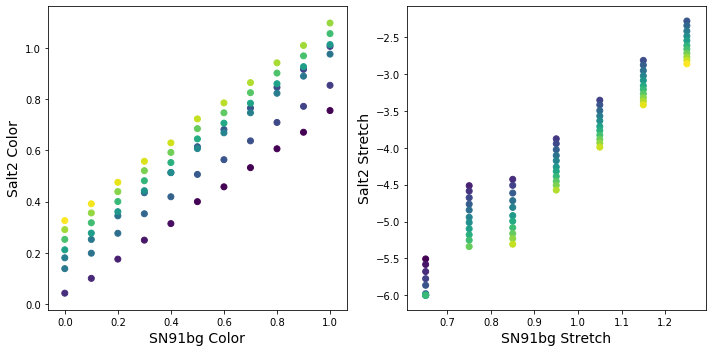

In [20]:
scatter_plot_parameters(bg_parameters, s2_parameters)


In [21]:
def subplot_imshow(x, y, z, axis, **kwargs):
    """Imshow values with contours
    
    Args:
        x     (array): An array of x values
        y     (array): An array of y values
        z     (array): A 2d array of z values
        axis   (Axis): matplotlib axis to plot on
        vmin  (float): Lower limit for imshow
        vmax  (float): Upper limit for imshow
        limit (float): A value indicating the LSST 5 sigma limit
        Any other arguments for ``axis.imshow``
        
    Returns:
        A matplotlib figure
    """

    axis.set_xlim(min(x), max(x))
    axis.set_ylim(min(y), max(y))
    extent = [min(x), max(x), min(y), max(y)]
    
    im = axis.imshow(
        z, 
        origin='lower', 
        interpolation='bilinear',
        extent=extent, 
        aspect='auto',
        cmap='bwr',
        **kwargs
    )
    
    return im

def imshow_parameters(simulated_params, fit_params):
    """Plot fitted parameters against simulated parameters as a color plot
    
    Args:
        simulated_params (Table): A table of simulated parameter values
        fit_params       (Table): A table of fitted parameter values
        
    Returns:
        A matplotlib figure
        An array with the axes of the figure
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    x = simulated_params['x1']
    y = simulated_params['c']
    
    z1 = [fit_params['c'][simulated_params['x1'] == x1] for x1 in set(simulated_params['x1'])]
    im1 = subplot_imshow(x, y, z1, axes[0])
    axes[0].set_xlabel('91bg Stretch', fontsize=14)
    axes[0].set_ylabel('91bg Color', fontsize=14)
    axes[0].set_title('SALT 2.4 Color', fontsize=14)

    cbar_ax_1 = fig.add_axes([0.41, 0.15, 0.05, 0.7])
    fig.colorbar(im1, cax=cbar_ax_1)

    z2 = [fit_params['x1'][simulated_params['c'] == c] for c in set(simulated_params['c'])]
    im2 = subplot_imshow(x, y, z2, axes[1])
    axes[1].set_xlabel('91bg Stretch', fontsize=14)
    axes[1].set_ylabel('91bg Color', fontsize=14)
    axes[1].set_title('SALT 2.4 Stretch', fontsize=14)

    cbar_ax_2 = fig.add_axes([0.92, 0.15, 0.05, 0.7])
    fig.colorbar(im2, cax=cbar_ax_2)

    plt.subplots_adjust(wspace=0.9)
    
    return fig, axes


(<Figure size 864x360 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1302d9c90>,
       dtype=object))

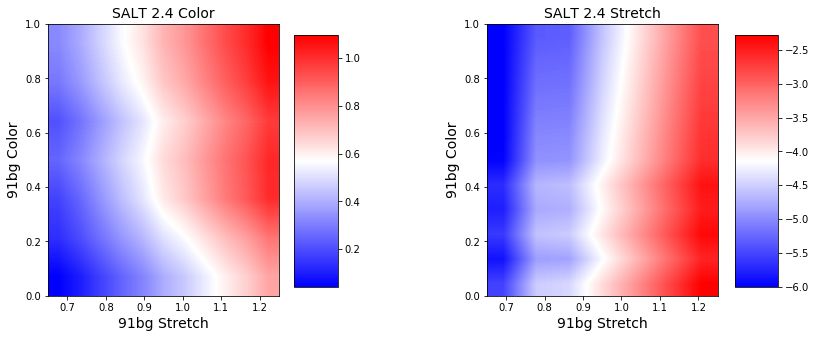

In [22]:
imshow_parameters(bg_parameters, s2_parameters)


## Comparison with Hsiao <a id='hsiao'></a>

Comparing with Salt2 allows us to think of terms like "stretch" and "color" on a familiar footing. However, in practice we are more interested in the Hsiao model since it has a broader model range. We here consider a custom version of the sncosmo `hsiao` model where a stretch parameter `x1` has been added.


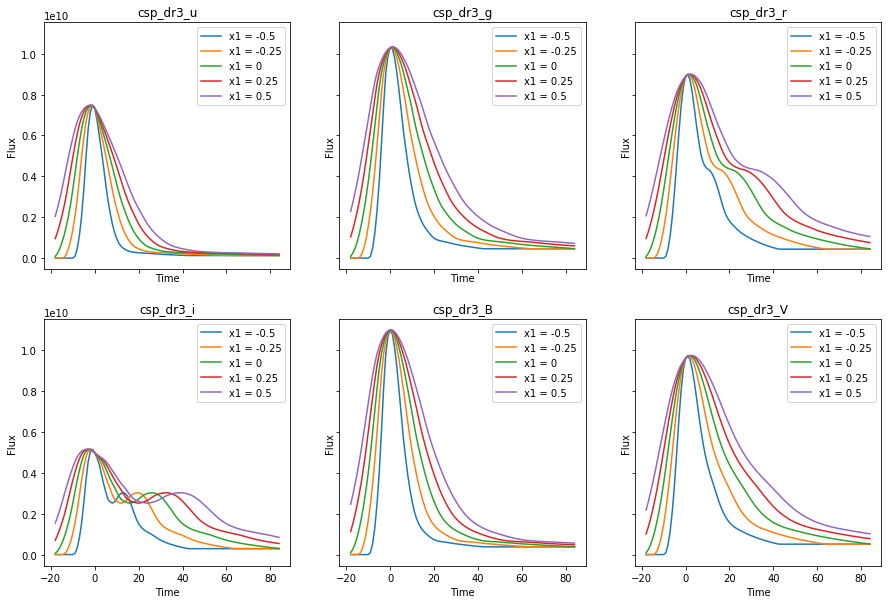

In [23]:
plot_flux_for_param(sncosmo.get_source('hsiao_x1'), 'x1', (-.5, -.25, 0, .25, .5))
plt.show()


In [24]:
def compare_model_to_hsiao(source):
    """Compare a model's normalized lightcurve against the hsaio model
    
    Args:
        source (Source): An sncosmo source
        
    Returns:
        A matplotlib figure
        An array with the axes of the figure
    """
    
    hsiao = sncosmo.get_source('hsiao_x1')

    lc = sncosmo.realize_lcs(
        observations, 
        sn91bg, 
        [dict(zip(sn91bg.param_names, sn91bg.parameters))]
    )[0]
    
    _, fitted_hsiao = sncosmo.fit_lc(
        lc, 
        sncosmo.Model(hsiao), 
        ['amplitude', 'x1'], 
        bounds={'x1': (-.5, .5)})
    
    bands = [
        'LSSTu',
        'LSSTg',
        'LSSTr',
        'LSSTi',
        'LSSTz',
        'LSSTy'
    ]

    phase = np.arange(-20, 50)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)
    for band, axis in zip(bands, axes.flatten()):
        hflux = hsiao.bandflux(band, phase)
        hflux_fitted = fitted_hsiao.bandflux(band, phase)
        sflux = source.bandflux(band, phase)
        
        # Normalize model light curve
        hflux_fitted /= np.max(hflux_fitted)
        hflux /= np.max(hflux)
        sflux /= np.max(sflux)

        # axis.plot(phase, hflux, label=f'Normal SNIa ({band[-1]}-band)')
        axis.plot(phase, hflux_fitted, label=f'Normal SNIa ({band[-1]}-band)')
        axis.plot(phase, sflux, label=f'SN91bg-like ({band[-1]}-band)')

        axis.set_ylim(0, axis.get_ylim()[-1])
        axis.legend(loc='upper right')
        
    plt.tight_layout()
    for axis in axes[:, 0]:
        axis.set_ylabel('Normalized Flux', fontsize=14)

    for axis in axes[-1]:
        axis.set_xlabel('Phase', fontsize=14)
        
    return fig, axes


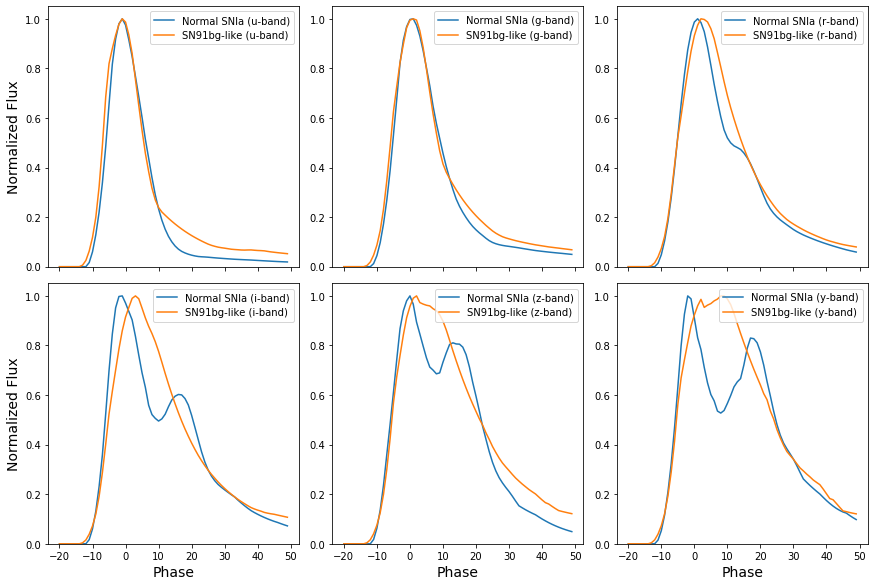

In [25]:
fig, axes = compare_model_to_hsiao(sn91bg)
plt.show()


## Fits to Real Data <a id='fits_to_data'></a>

We apply both models to real data of a normal and 91bg-like SNe.

In [122]:
def convert_to_zp(data, zp):
    """Convert the flux and fluxerr columns of a table to a new zp
    
    Returns a copy
    
    Args:
        data (Table): The table to modify
        zp (float): The new zp
    
    Returns:
        An astropy Table
    """
    
    data = data.copy()
    conv_factor = 10 ** ((data['zp'] - zp) / -2.5)
    data['flux'] *= conv_factor
    data['fluxerr'] *= conv_factor
    data['zp'] = zp
    return data

def create_residuals_axis(fig, axis):
    """Add an axis for plotting residuals below an existing axis

    Args:
        fig (Figure): The figure to add an axis to
        axis  (Axis): The figure to add an axis below

    Returns:
        The new axis
    """

    # Determine axis position
    position = axis.get_position()
    height = position.y1 - position.y0
    position.y1 = position.y0
    position.y0 = position.y1 - .3 * height
    
    # Create axis
    resid_axis = fig.add_axes(position)
    resid_axis.tick_params(labelsize=8)
    resid_axis.axhline(0, color='grey')
    
    # Formatting
    axis.get_shared_x_axes().join(axis, resid_axis)
    axis.set_xticks([])
    resid_axis.set_ylim(-.5, .5)
    resid_axis.set_yticks([-.5, 0, 5])
    resid_axis.set_yticklabels(['- 0.50', '0', ''])

    return resid_axis


def format_axis(axis, max_mag, phase_range, y_max, zp):
    """Format an axis to a consistent design

    Args:
        axis         (Axis): The axis to format
        max_mag     (float): The maximum value for the magnitude axis 
        phase_range (tuple): Range for the x axis 
        y_max       (float): The maximum value for the flux axis 
        zp          (float): The flux zero-point

    Returns:
        The magnitude twin-y axis
        An array of labels applied to the magnitude axis
    """
    
    axis.set_ylim(0, y_max)
    axis_labels = [f'{val:.2f}' for val in axis.get_yticks()]
    axis.set_yticklabels(axis_labels)
    
    axis.set_xlim(phase_range[0], phase_range[0] + 50)
    axis.set_xticklabels([])
    
    axis.tick_params(labelsize=8)
    mag_axis = axis.twinx()

    # Major tick marks for magnitude axis
    major_mag_labels = np.arange(10, max_mag)
    major_flux_labels = 10 ** ((major_mag_labels - zp) / -2.5)
    mag_axis.set_yticks(major_flux_labels)
    mag_axis.set_yticklabels([])

    # Minor tick marks for magnitude axis
    minor_mag_labels = np.arange(10, max_mag + 1, .25)
    minor_flux_labels = 10 ** ((minor_mag_labels - zp) / -2.5)
    mag_axis.set_yticks(minor_flux_labels, minor=True)
    mag_axis.set_ylim(axis.get_ylim())

    return mag_axis, major_mag_labels


In [123]:
def fit_dr3_data(data, mjd_offset):
    """Fit data from Dr3 in the blue and red bands

    Args:
        data       (Table): The data to fit 
        mjd_offset (float): Offset to apply to date 

    Returns:
        The blue bands data
        The red bands data
        The collective data
        A tuple with the blue and red fit params 
    """

    data['time'] -= mjd_offset

    # Fit data in the red and blue bands
    blue_data, red_data = utils.split_data(
        data, dr3.band_names, dr3.lambda_effective, data.meta['z'])

    fit_results = fitting.run_collective_fits(
        obj_id=data.meta['obj_id'],
        data=data,
        fit_func=sncosmo.fit_lc,
        band_names=dr3.band_names,
        lambda_eff=dr3.lambda_effective,
        priors_hs={'z': data.meta['z']},
        priors_bg={'z': data.meta['z']},
        kwargs_hs={'bounds': {'x1': (-.5, .5)}},
        kwargs_bg={'bounds': {'x1': (0.65, 1.25), 'c': (0, 1)}}
    )

    # Separate fit results into red and blue
    fit_results = fit_results.to_pandas().set_index(['band', 'source'])
    collective_params = fit_results.loc['blue'], fit_results.loc['red']
    collective_data = utils.split_data(
        data,
        dr3.band_names,
        dr3.lambda_effective,
        data.meta['z'])

    return blue_data, red_data, collective_data, collective_params


def compare_fits_to_csp_data(data, max_mag, mjd_offset=0):
    """Plot fits of the hsiao_x1 and 91bg model

    Args:
        data (Table): The data to fit
        is_bg (bool): Whether the target is a 91bg

    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """

    data = data.copy()
    blue_data, red_data, collective_data, collective_params = \
        fit_dr3_data(data, mjd_offset)

    # Define models
    sn91bg_source = sncosmo.get_source('sn91bg', version='hsiao_phase')
    sn91bg = sncosmo.Model(source=sn91bg_source)
    hsiao = sncosmo.Model(source='hsiao_x1')
    salt2 = sncosmo.Model(source='salt2')

    # Some arrays used in plotting
    phase_range = min(data['time']) - 5, min(data['time']) + 100
    phase_arr = np.arange(*phase_range)

    fig, axes = plt.subplots(2, 3, figsize=(7.5, 5), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=.6)

    resid_axes = []
    plot_data = zip(axes, collective_params, collective_data)
    for axis_row, bandset_params, bandset_data in plot_data:

        # Set modules to fitted parameters
        hsiao_params = bandset_params.loc['hsiao_x1']
        hsiao.update({p: hsiao_params[p] for p in hsiao.param_names})

        sn91bg_params = bandset_params.loc['sn91bg']
        sn91bg.update({p: sn91bg_params[p] for p in sn91bg.param_names})

        resid_axes_row = []
        for axis, model in zip(axis_row, (salt2, hsiao, sn91bg)):
            resid_axis = create_residuals_axis(fig, axis)
            resid_axes_row.append(resid_axis)

            for i, band_data in enumerate(
                    bandset_data.group_by('band').groups):
                band_name = band_data['band'][0]
                zp = band_data['zp'][0]
                zpsys = band_data['zpsys'][0]

                axis.scatter(
                    x=band_data['time'],
                    y=band_data['flux'],
                    label=band_name.split('_')[-1],
                    color=f'C{i}',
                    marker='.^sv.^sv.^sv'[i],
                    s=5
                )

                axis.errorbar(
                    x=band_data['time'],
                    y=band_data['flux'],
                    yerr=band_data['fluxerr'],
                    linestyle='',
                    color=f'C{i}',
                )

                if model.source.name == 'salt2':
                    salt2.set(z=data.meta['z'])
                    _, model = sncosmo.fit_lc(blue_data, salt2,
                                              salt2.param_names[1:])

                model_flux = model.bandflux(band_name, phase_arr, zp, zpsys)
                axis.plot(phase_arr, model_flux, color=f'C{i}')

                resid_flux = model.bandflux(band_name, band_data['time'], zp, zpsys)
                percent_resid = (band_data['flux'] - resid_flux) / band_data['flux']
                resid_axis.scatter(band_data['time'], percent_resid, s=5)
                resid_axis.set_ylim(-.5, .5)

                resid_axis.xaxis.set_minor_locator(AutoMinorLocator(2))
                resid_axis.yaxis.set_minor_locator(AutoMinorLocator(2))
                axis.yaxis.set_minor_locator(AutoMinorLocator(2))
            
        resid_axes.append(resid_axes_row)

    # Format axes and add magnitude labels
    for r, (axis_row, resid_row) in enumerate(zip(axes, resid_axes)):
        y_max = np.max([axis.get_ylim()[-1] for axis in axis_row])
        
        for c, (axis, resid_axis) in enumerate(zip(axis_row, resid_row)):
            mag_axis, major_mag_labels = format_axis(
                axis, max_mag, phase_range, y_max, zp)

            if c == 0:
                axis.set_ylabel(f'Flux (ZP = {zp})', fontsize=10, labelpad=15)
                resid_axis.set_ylabel(r'$\Delta$F (%)', fontsize=10, labelpad=10)
                
            else:
                resid_axis.set_yticklabels([])

            if c == len(axis_row) - 1:
                mag_axis.set_ylabel('Magnitude', rotation=270, fontsize=10, labelpad=20)
                mag_axis.set_yticklabels(major_mag_labels)
                axis.legend()

    resid_axes[1][1].set_xlabel(f'Date (MJD - {mjd_offset})', fontsize=10, labelpad=10)
    for axis, title in zip(axes[0], ('SALT 2.4', 'Modified H07', 'SN91bg')):
        axis.set_title(title, fontsize=10)

    return fig, axes


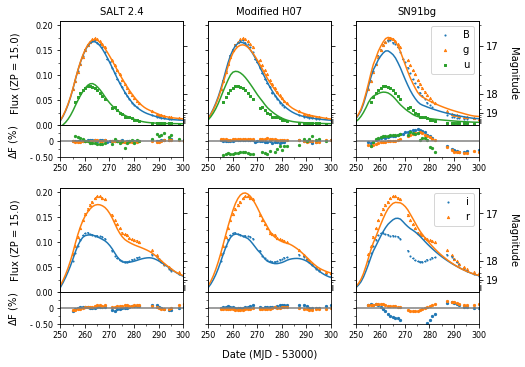

In [124]:
normal_data = dr3.get_data_for_id('2004ef')
normal_data = normal_data[normal_data['band'] != 'csp_dr3_Ydw']
normal_data = normal_data[normal_data['band'] != 'csp_dr3_Y']
normal_data = normal_data[normal_data['band'] != 'csp_dr3_H']
normal_data = normal_data[normal_data['band'] != 'csp_dr3_J']
normal_data = normal_data[normal_data['band'] != 'csp_dr3_V']
normal_data = normal_data[normal_data['band'] != 'csp_dr3_V0']
normal_data['time'] -= 2400000.5

normal_data.remove_columns(['mag', 'mag_err'])
normal_data = convert_to_zp(normal_data, 15)

fig, axes = compare_fits_to_csp_data(normal_data, 20, mjd_offset=53000)
axes[0][0].set_xlim(250, 300)

plt.savefig(fig_dir / 'fit_of_normal_sn.pdf', bbox_inches='tight')
plt.show()


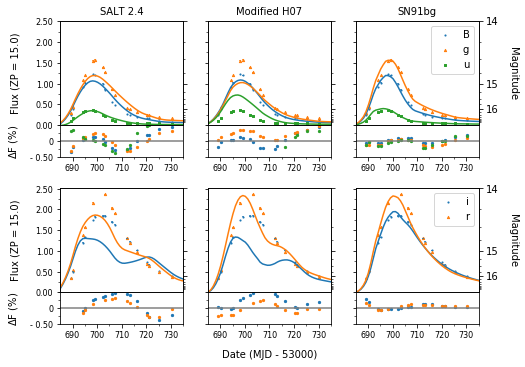

In [125]:
bg_data = dr3.get_data_for_id('2005ke')
bg_data = bg_data[bg_data['band'] != 'csp_dr3_Ydw']
bg_data = bg_data[bg_data['band'] != 'csp_dr3_Y']
bg_data = bg_data[bg_data['band'] != 'csp_dr3_H']
bg_data = bg_data[bg_data['band'] != 'csp_dr3_J']
bg_data = bg_data[bg_data['band'] != 'csp_dr3_V']
bg_data = bg_data[bg_data['band'] != 'csp_dr3_V0']
bg_data['time'] -= 2400000.5

bg_data.remove_columns(['mag', 'mag_err'])
bg_data = convert_to_zp(bg_data, 15)

fig, axes = compare_fits_to_csp_data(bg_data, 17, 53000)
axes[0][0].set_xlim(685, 735)

plt.savefig(fig_dir / 'fit_of_91bg.pdf', bbox_inches='tight')
plt.show()


In [134]:
def compare_fits_to_sdss_data(data, jd_offset=0):
    """Plot fits of the hsiao_x1 and 91bg model

    Args:
        data (Table): The data to fit
        is_bg (bool): Whether the target is a 91bg

    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """

    data = data.copy()
    data['time'] -= jd_offset

    # Fit data in the red and blue bands
    blue_data, red_data = utils.split_data(
        data, sako18.band_names, sako18.lambda_effective, data.meta['z'])

    fitting_args = dict(
        obj_id=data.meta['obj_id'],
        data=data,
        fit_func=sncosmo.fit_lc,
        priors_hs={'z': data.meta['z']},
        priors_bg={'z': data.meta['z']},
        kwargs_hs={'bounds': {'x1': (-.5, .5)}},
        kwargs_bg={'bounds': {'x1': (0.65, 1.25), 'c': (0, 1)}}
    )
    
    collective_results = fitting.run_collective_fits(
        band_names=sako18.band_names,
        lambda_eff=sako18.lambda_effective,
        **fitting_args)
    
    collective_results = collective_results.to_pandas().set_index(['band', 'source'])

    band_results = fitting.run_band_fits(**fitting_args)
    band_results = band_results.to_pandas().set_index(['band', 'source'])
        
    # Define models
    dust_kw = dict(effects=[sncosmo.F99Dust()], effect_names=['mw'], effect_frames=['obs'])
    sn91bg_source = sncosmo.get_source('sn91bg', version='hsiao_phase')
    sn91bg = sncosmo.Model(sn91bg_source, **dust_kw)
    hsiao = sncosmo.Model('hsiao_x1', **dust_kw)

    # Some arrays used in plotting
    phase_range = min(data['time']) - 10, min(data['time']) + 75
    phase_arr = np.arange(*phase_range)

    num_bands = len(set(data['band']))
    fig, axes = plt.subplots(num_bands, 2, figsize=(5, 13), sharex=True, sharey='row')
    plt.subplots_adjust(hspace=.6)

    resid_axes = []
#    ymax = 1.05 * max(data['flux'] + data['fluxerr'])
    for band in set(data['band']):
        band_data = data[data['band'] == band]
        zp = band_data['zp'][0]
        
        band_abbrev = band.split('_')[-1][0]
        i = 'ugriz'.index(band_abbrev)
        axis_row = axes[i]
        
        for j, (axis, model) in enumerate(zip(axis_row, (hsiao, sn91bg))):
            resid_axis = create_residuals_axis(fig, axis)
            resid_axis.set_ylim(-.5, .5)
            
            axis.scatter(
                band_data['time'], band_data['flux'], 
                s=8, color='k', label=fr'{band_abbrev}-band' if j == 0 else None)
            
            axis.errorbar(
                band_data['time'], band_data['flux'], 
                band_data['fluxerr'], linestyle='none',
                color='k'
            )
            
            # Plot fits to all data
            all_fit_params = band_results.loc['all', model.source.name]
            model.update({p: all_fit_params[p] for p in model.param_names})
            all_fit_flux = model.bandflux(band, phase_arr, zp, 'AB')
            axis.plot(
                phase_arr, all_fit_flux, 
                color='k',
                linestyle=':',
                label='All data fit' if j == 1 else None)
            
            all_fit_residuals = band_data['flux'] - model.bandflux(band, band_data['time'], zp, 'AB')
            resid_axis.scatter(band_data['time'],  all_fit_residuals, s=10)
            resid_axis.errorbar(
                band_data['time'],  
                all_fit_residuals, 
                band_data['fluxerr'], 
                linestyle='none'
            )
            
            # Plot band fits
            band_fit_params = band_results.loc[band, model.source.name]
            model.update({p: band_fit_params[p] for p in model.param_names})
            band_fit_flux = model.bandflux(band, phase_arr, zp, 'AB')
            axis.plot(
                phase_arr, band_fit_flux, 
                linestyle='-',
                label='Band fit' if j == 1 else None)
            
            band_fit_residuals = band_data['flux'] - model.bandflux(band, band_data['time'], zp, 'AB')
            resid_axis.scatter(band_data['time'],  band_fit_residuals, s=10)
            resid_axis.errorbar(
                band_data['time'],  
                band_fit_residuals, 
                band_data['fluxerr'], 
                linestyle='none'
            )

            # Plot collective fits
            band_set = 'blue' if band in blue_data['band'] else 'red'
            coll_fit_params = collective_results.loc[band_set, model.source.name]
            model.update({p: coll_fit_params[p] for p in model.param_names})
            collective_fit_flux = model.bandflux(band, phase_arr, zp, 'AB')
            axis.plot(
                phase_arr, collective_fit_flux, 
                linestyle='--',
                linewidth=2,
                label='Collective fit' if j == 1 else None)
            
            collective_fit_residuals = band_data['flux'] - model.bandflux(band, band_data['time'], zp, 'AB')
            resid_axis.scatter(band_data['time'],  collective_fit_residuals, s=10)
            resid_axis.errorbar(
                band_data['time'],  
                collective_fit_residuals, 
                band_data['fluxerr'], 
                linestyle='none'
            )
            
            ymax = max(band_data['flux'] + band_data['fluxerr'])
            ymax = max(ymax, axis.get_ylim()[-1])
            for f in (band_fit_flux, collective_fit_flux, all_fit_flux):
                ymax = max(ymax, max(f))
            
            
            mag_axis, major_mag_labels = format_axis(axis, 24, phase_range, 1.05 * ymax, zp)
            resid_axis.xaxis.set_minor_locator(AutoMinorLocator(2))
            axis.yaxis.set_minor_locator(AutoMinorLocator(2))

            if i == 0:
                model_name = model.source.name
                title = {'hsiao_x1': 'Modified H07', 'sn91bg': 'SN91bg'}[model_name]
                axis.set_title(title)
                axis.legend(loc='upper left')
            
            if i == len(axes) - 1:
                resid_axis.set_xlabel(f'Time (MJD - {jd_offset - 2_400_000})', fontsize=12, labelpad=14)
                
            if j == 0:
                axis.legend(loc='upper left')
                
            else:
                resid_axis.set_yticklabels([])
                mag_axis.set_yticklabels(major_mag_labels)
                mag_axis.set_ylabel('Magnitude', rotation=270, fontsize=12, labelpad=15)

            for ax in (axis, resid_axis, mag_axis):
                ax.tick_params(axis='both', which='major', labelsize=10)
            
        axis_row[0].set_ylabel(f'Flux (ZP = {data["zp"][0]})', fontsize=12, labelpad=10)
        
    axis.set_xlim(min(phase_arr), max(phase_arr))
    return fig, axes


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


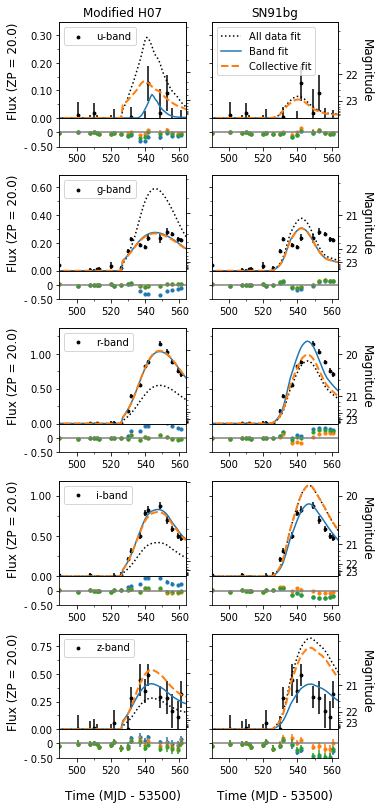

In [135]:
sdss_object_data = convert_to_zp(sako18.get_data_for_id('15749'), 20)
compare_fits_to_sdss_data(sdss_object_data, 2_453_500)
plt.xlim(xmin=490)
plt.savefig(fig_dir / '15749_fit_comparison.pdf', bbox_inches='tight')
